In [41]:
import os
import torch
import pandas as pd
import numpy as np
import re
import ast
import json
from functools import reduce
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
%matplotlib inline

**HEART**

In [42]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df



# Process train data for each channel
train_fin = load_and_process('train_embeddings_long_axis_ch0_imbalanced_monai.csv', 'embedding0')
train_fin1 = load_and_process('train_embeddings_long_axis_ch1_imbalanced_monai.csv', 'embedding1')
train_fin2 = load_and_process('train_embeddings_long_axis_ch2_imbalanced_monai.csv', 'embedding2')

# Merge train DataFrames
train_df_x = pd.merge(train_fin, train_fin1, on=['image_path', 'label'], how='inner')
train_df_heart = pd.merge(train_df_x, train_fin2, on=['image_path', 'label'], how='inner')

# Extract IID from image path for train
train_df_heart['IID'] = train_df_heart['image_path'].str.extract(r'Processed/(\d+).npy').astype(int)

# Process test data for each channel
test_fin = load_and_process('test_embeddings_long_axis_ch0_imbalanced_monai.csv', 'embedding0')
test_fin1 = load_and_process('test_embeddings_long_axis_ch1_imbalanced_monai.csv', 'embedding1')
test_fin2 = load_and_process('test_embeddings_long_axis_ch2_imbalanced_monai.csv', 'embedding2')

# Merge test DataFrames
test_df_x = pd.merge(test_fin, test_fin1, on=['image_path', 'label'], how='inner')
test_df_heart = pd.merge(test_df_x, test_fin2, on=['image_path', 'label'], how='inner')

# Extract IID from image path for test
test_df_heart['IID'] = test_df_heart['image_path'].str.extract(r'Processed/(\d+).npy').astype(int)

# Print results (optional, for verification)
print(train_df_heart['label'].value_counts())
print(test_df_heart['label'].value_counts())

label
0    26358
1     4391
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [43]:
# Define a function to load and process datasets
def load_and_process(file_path, embedding_col):
    df = pd.read_csv(file_path).rename(columns={'embedding': embedding_col}).drop_duplicates()
    df[embedding_col] = df[embedding_col].apply(lambda x: np.array(json.loads(x)))
    return df

# Process train and test datasets
train_df_aortic = load_and_process('train_embeddings_aortic_monai.csv', 'aortic_embeddings')
test_df_aortic = load_and_process('test_embeddings_aortic_monai.csv', 'aortic_embeddings')

# Extract IID from image path for both train and test
train_df_aortic['IID'] = train_df_aortic['image_path'].str.extract(r'/(\d+)_\d+\.npy').astype(int)
test_df_aortic['IID'] = test_df_aortic['image_path'].str.extract(r'/(\d+)_\d+\.npy').astype(int)  # Fixed parentheses

# Print results (optional, for verification)
print(train_df_aortic['label'].value_counts())
print(test_df_aortic['label'].value_counts())

label
1    3287
0    3287
Name: count, dtype: int64
label
0    200
1    200
Name: count, dtype: int64


In [44]:
train_ecg = pd.read_csv('Final_Datasets/train_imbalanced_ecg.csv')
train_ecg = train_ecg.rename(columns = {'CAD':'label'})
print(train_ecg['label'].value_counts())
train_ecg.head()

label
0    26350
1     4326
Name: count, dtype: int64


,FilePath_ECG,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude
0,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,4465837,1,78.0,376.0,431.0,754.0,755.0,302.500000,339.583333,185.400000
1,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,4611362,1,78.0,404.0,423.0,908.0,905.0,336.500000,562.000000,125.416667
2,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,4032904,1,96.0,398.0,429.0,862.0,855.0,45.333333,574.833333,104.250000
3,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,5099267,1,132.0,440.0,471.0,868.0,865.0,854.000000,319.555556,175.750000
4,/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,3910439,1,78.0,354.0,430.0,676.0,670.0,104.285714,515.666667,127.583333


In [45]:
# List of datasets to merge sequentially
datasets = [
    train_df_heart,
    train_df_aortic,
    train_ecg,
]

# Drop the 'image path' column if it exists in any dataset
datasets = [df.drop(columns=['image_path'], errors='ignore') for df in datasets]


train_df_full = reduce(lambda left, right: pd.merge(left, right, on=['IID', 'label'], how='inner'), datasets)

# Display the resulting dataframe
train_df_full.head()

,embedding0,label,embedding1,embedding2,IID,aortic_embeddings,FilePath_ECG,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude
0,"[0.6222007274627686, 0.857754111289978, 0.8616...",0,"[0.9138720631599426, 0.8331859707832336, 1.710...","[0.8524302840232849, 1.5004643201828003, 0.882...",3267458,"[1.099939227104187, 0.8363233208656311, 0.7002...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000
1,"[0.8524421453475952, 1.1529635190963745, 0.927...",0,"[0.8691175580024719, 1.1014518737792969, 1.953...","[0.7155594825744629, 1.5444616079330444, 1.231...",4086644,"[1.517000436782837, 0.8485708832740784, 0.7001...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000
2,"[0.8198446035385132, 1.0692479610443115, 0.942...",1,"[0.7523369193077087, 1.1102197170257568, 1.910...","[0.6888049840927124, 1.1276196241378784, 0.869...",4236006,"[0.8442996144294739, 0.659028172492981, 0.6841...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667
3,"[0.6215686202049255, 0.9250015020370483, 0.959...",0,"[0.6947037577629089, 1.1452747583389282, 1.401...","[0.9793095588684082, 1.412980079650879, 0.7921...",2003477,"[1.0216706991195679, 0.6351988315582275, 0.909...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000
4,"[0.5215746164321899, 1.1620604991912842, 0.858...",0,"[0.6306257247924805, 1.0514334440231323, 1.562...","[1.0788642168045044, 2.0992400646209717, 0.792...",1817039,"[1.4068950414657593, 0.7599076628684998, 0.730...",/corral/utexas/UKB-Imaging-Genetics/temp_imagi...,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545


In [46]:
train_df_full['label'].value_counts()

label
1    2899
0    2685
Name: count, dtype: int64

In [47]:
# List of test datasets to merge sequentially
test_datasets = [
    test_df_heart,
    test_df_aortic
]

# Drop the 'image path' column if it exists in any dataset
test_datasets = [df.drop(columns=['image_path'], errors='ignore') for df in test_datasets]

test_df_full = reduce(lambda left, right: pd.merge(left, right, on=['IID', 'label'], how='inner'), test_datasets)

# Display the resulting dataframe
test_df_full.head()

,embedding0,label,embedding1,embedding2,IID,aortic_embeddings
0,"[1.0895754098892212, 1.2075629234313965, 1.048...",0,"[0.5463781356811523, 0.9533547163009644, 1.702...","[1.0024220943450928, 1.2877448797225952, 1.076...",4890586,"[1.4666997194290161, 0.8146945238113403, 0.733..."
1,"[0.7500353455543518, 0.5545405745506287, 0.863...",0,"[0.8292922973632812, 0.8665534853935242, 1.341...","[0.7049407958984375, 0.8878511786460876, 0.806...",2201189,"[1.750013828277588, 0.7056908011436462, 0.6797..."
2,"[0.7465672492980957, 1.0462931394577026, 0.827...",1,"[0.8891360759735107, 0.7426362037658691, 1.191...","[0.9128535389900208, 0.8650694489479065, 0.742...",3646967,"[1.196069598197937, 0.8318781852722168, 0.6023..."
3,"[1.2226277589797974, 2.3310561180114746, 1.097...",0,"[0.6006484627723694, 1.6089153289794922, 2.282...","[1.2725563049316406, 1.6649129390716553, 1.630...",2032754,"[1.711975336074829, 0.9903967380523682, 0.5838..."
4,"[1.1025010347366333, 1.4001193046569824, 0.854...",1,"[0.9131760597229004, 0.6301987767219543, 1.686...","[0.8072603940963745, 1.216403841972351, 1.0066...",2434644,"[0.9530894160270691, 0.9407976865768433, 0.623..."


In [48]:
test_df_full['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

**HELPER FUNCTIONS**

In [49]:
def convert_to_array(embedding):
    """
    Converts a string representation of a list into a NumPy array.
    
    Args:
        embedding (str or list): Embedding to convert.
        
    Returns:
        np.ndarray: Converted embedding.
    """
    if isinstance(embedding, str):
        return np.array(ast.literal_eval(embedding))  # Safely parse string to list
    elif isinstance(embedding, (list, np.ndarray)):
        return np.array(embedding)
    else:
        raise ValueError(f"Unsupported embedding format: {type(embedding)}")

In [50]:
def fit_pca_on_train(df, embedding_cols, n_components=10):
    """
    Fits PCA on the train embeddings and adds PCA-transformed features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the embeddings.
        embedding_cols (list of str): Column names with embeddings.
        n_components (int): Number of PCA components to fit.

    Returns:
        tuple: Updated DataFrame with PCA features and a dictionary of fitted PCA objects.
    """
    pca_dict = {}
    for col in embedding_cols:
        # Ensure the embeddings are numpy arrays
        embeddings = np.vstack(df[col].values)
        
        # Fit PCA
        pca = PCA(n_components=n_components)
        pca.fit(embeddings)
        pca_dict[col] = pca
        
        # Transform and add PCA features to the DataFrame
        pca_features = pca.transform(embeddings)
        pca_feature_cols = [f'pca_{col}_{i+1}' for i in range(n_components)]
        df[pca_feature_cols] = pca_features
    
    return df, pca_dict

In [51]:
def transform_embeddings_with_pca(df, embedding_cols, pca_dict):
    """
    Transforms embeddings using pre-fitted PCA and adds PCA features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the embeddings to transform.
        embedding_cols (list of str): Column names with embeddings.
        pca_dict (dict): Dictionary of pre-fitted PCA objects for each column.

    Returns:
        pd.DataFrame: Updated DataFrame with PCA-transformed features added.
    """
    for col in embedding_cols:
        # Ensure the embeddings are numpy arrays
        embeddings = np.vstack(df[col].values)
        
        # Transform using the pre-fitted PCA
        pca = pca_dict[col]
        pca_features = pca.transform(embeddings)
        
        # Add PCA features to the DataFrame
        pca_feature_cols = [f'pca_{col}_{i+1}' for i in range(pca.n_components)]
        df[pca_feature_cols] = pca_features
    
    return df

In [52]:
# Embedding Columns and PCA
embedding_columns = [
    'embedding0', 
    'embedding1', 
    'embedding2', 
    'aortic_embeddings'
    
]
# Convert all embeddings to NumPy arrays
for col in embedding_columns:
    train_df_full[col] = train_df_full[col].apply(convert_to_array)

# Perform PCA on the embedding columns
train_df_full, pca_dict = fit_pca_on_train(train_df_full, embedding_columns)


# Generate PCA columns dynamically
pca_columns = [f'pca_{col}_{i+1}' for col in embedding_columns for i in range(10)]

# Select relevant columns for analysis
columns_to_keep = [
    'IID', 'label', 'QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval',
    'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude'
] + pca_columns
train_df = train_df_full[columns_to_keep]

In [53]:
train_df.head()

,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,...,pca_aortic_embeddings_1,pca_aortic_embeddings_2,pca_aortic_embeddings_3,pca_aortic_embeddings_4,pca_aortic_embeddings_5,pca_aortic_embeddings_6,pca_aortic_embeddings_7,pca_aortic_embeddings_8,pca_aortic_embeddings_9,pca_aortic_embeddings_10
0,3267458,0,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000,...,0.528698,-2.531287,-0.748501,-0.060940,-0.083894,0.185096,-0.204538,0.445282,-0.137217,0.125697
1,4086644,0,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000,...,10.796318,-1.779743,1.153168,-0.073398,0.762877,-0.354878,-0.056882,0.388396,0.206003,0.110710
2,4236006,1,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667,...,-4.934797,-2.489771,0.194454,-0.141503,-0.119386,0.058418,0.019503,-0.562422,-0.042396,0.215217
3,2003477,0,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000,...,-6.082216,-3.248394,-0.297225,-0.081606,0.225537,0.420810,-0.358363,0.311298,-0.373355,0.022226
4,1817039,0,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545,...,9.580060,-3.020190,0.330759,-0.647304,0.599380,-0.356721,-0.201501,0.293604,0.338300,0.094858


In [54]:
# PRS
prs = pd.read_csv('prs_output_CAD_PRS_new.txt', sep='\t')
prs = prs.rename(columns={'SCORE1_SUM': 'PRS'})[['IID', 'PRS']]
train = pd.merge(train_df, prs, on='IID', how='inner')

# Age
age = pd.read_csv('../fid21003.csv').rename(columns={'eid': 'IID', '21003-2.0': 'age'})[['IID', 'age']]
train = pd.merge(train, age, on='IID', how='inner')

# Sex
sex = pd.read_csv('../fid31.csv').rename(columns={'eid': 'IID', '31-0.0': 'sex'})[['IID', 'sex']]
train = pd.merge(train, sex, on='IID', how='inner')

# BMI
bmi = pd.read_csv('../fid21001.csv').rename(columns={'eid': 'IID', '21001-0.0': 'bmi'})[['IID', 'bmi']]
train = pd.merge(train, bmi, on='IID', how='inner')

# LDL
ldl = pd.read_csv('../fid30780.csv').rename(columns={'eid': 'IID', '30780-0.0': 'ldl'})[['IID', 'ldl']]
train = pd.merge(train, ldl, on='IID', how='inner')

# Triglycerides
trig = pd.read_csv('../fid30870.csv').rename(columns={'eid': 'IID', '30870-0.0': 'trig'})[['IID', 'trig']]
train = pd.merge(train, trig, on='IID', how='inner')

# Total Cholesterol
tc = pd.read_csv('../fid30690.csv').rename(columns={'eid': 'IID', '30690-0.0': 'total_cholestrol'})[['IID', 'total_cholestrol']]
train = pd.merge(train, tc, on='IID', how='inner')

# Smoking
smoking = pd.read_csv('../fid20116.csv').rename(columns={'eid': 'IID', '20116-0.0': 'smoking'})[['IID', 'smoking']]
train = pd.merge(train, smoking, on='IID', how='inner')


print(train.isnull().sum())


train = train.dropna()
print(train['label'].value_counts())
train.head()

IID                           0
label                         0
QRSDuration                   0
QTInterval                    0
QTCInterval                   0
RRInterval                    0
PPInterval                    0
MeanQAmplitude                0
MeanRAmplitude                0
MeanTAmplitude                0
pca_embedding0_1              0
pca_embedding0_2              0
pca_embedding0_3              0
pca_embedding0_4              0
pca_embedding0_5              0
pca_embedding0_6              0
pca_embedding0_7              0
pca_embedding0_8              0
pca_embedding0_9              0
pca_embedding0_10             0
pca_embedding1_1              0
pca_embedding1_2              0
pca_embedding1_3              0
pca_embedding1_4              0
pca_embedding1_5              0
pca_embedding1_6              0
pca_embedding1_7              0
pca_embedding1_8              0
pca_embedding1_9              0
pca_embedding1_10             0
pca_embedding2_1              0
pca_embe

,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,...,pca_aortic_embeddings_9,pca_aortic_embeddings_10,PRS,age,sex,bmi,ldl,trig,total_cholestrol,smoking
0,3267458,0,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000,...,-0.137217,0.125697,-8.82705,61.0,1,20.5966,1.947,0.827,3.737,0.0
1,4086644,0,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000,...,0.206003,0.110710,-7.71150,67.0,0,21.6128,2.917,1.406,5.806,1.0
2,4236006,1,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667,...,-0.042396,0.215217,-7.15006,65.0,1,23.9635,4.659,2.548,7.295,0.0
3,2003477,0,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000,...,-0.373355,0.022226,-8.02911,58.0,0,19.4213,2.249,0.815,4.011,0.0
4,1817039,0,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545,...,0.338300,0.094858,-9.53054,69.0,0,21.0381,3.640,0.791,6.083,1.0


In [55]:
dm = pd.read_csv('dm_case_control.csv')
train = pd.merge(train, dm, on='IID', how='inner')
train.head()

,IID,label,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,...,pca_aortic_embeddings_10,PRS,age,sex,bmi,ldl,trig,total_cholestrol,smoking,DM
0,3267458,0,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,251.500000,...,0.125697,-8.82705,61.0,1,20.5966,1.947,0.827,3.737,0.0,0
1,4086644,0,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,163.250000,...,0.110710,-7.71150,67.0,0,21.6128,2.917,1.406,5.806,1.0,0
2,4236006,1,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,210.416667,...,0.215217,-7.15006,65.0,1,23.9635,4.659,2.548,7.295,0.0,0
3,2003477,0,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,339.500000,...,0.022226,-8.02911,58.0,0,19.4213,2.249,0.815,4.011,0.0,0
4,1817039,0,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,72.454545,...,0.094858,-9.53054,69.0,0,21.0381,3.640,0.791,6.083,1.0,0


In [57]:
# Define embedding columns for PCA
embedding_columns = [
    'embedding0', 
    'embedding1', 
    'embedding2', 
    'aortic_embeddings'
]

# Convert all embeddings to NumPy arrays
for col in embedding_columns:
    test_df_full[col] = test_df_full[col].apply(convert_to_array)


# Perform PCA on embeddings and add PCA columns to the test DataFrame
test_df_full, pca_dict = fit_pca_on_train(test_df_full, embedding_columns, n_components=10)

# Generate PCA column names dynamically
pca_columns = [f'pca_{col}_{i+1}' for col in embedding_columns for i in range(10)]

# Extract only necessary columns for the next steps
test_df_full = test_df_full[['IID', 'label'] + pca_columns]
test_df_full.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,pca_aortic_embeddings_1,pca_aortic_embeddings_2,pca_aortic_embeddings_3,pca_aortic_embeddings_4,pca_aortic_embeddings_5,pca_aortic_embeddings_6,pca_aortic_embeddings_7,pca_aortic_embeddings_8,pca_aortic_embeddings_9,pca_aortic_embeddings_10
0,4890586,0,0.631282,2.211253,1.092452,-0.389791,0.228797,-0.114444,0.089976,0.783784,...,2.933953,0.256624,-0.064049,-0.589980,-0.456817,-0.866305,-0.660516,0.447814,-0.424877,0.909180
1,2201189,0,-4.278456,-3.219499,1.083042,0.208103,0.634662,0.242868,1.013933,0.222113,...,3.779756,0.600090,0.984905,-0.695777,-0.073450,0.411755,0.045013,0.182088,-0.483087,0.370246
2,3646967,1,-1.817479,2.961022,-0.267553,0.177392,-0.689986,0.263152,-0.042812,0.194133,...,-5.964573,2.459319,-0.487542,0.448769,0.135181,0.124807,0.378574,0.285983,-0.051859,0.260463
3,2032754,0,11.592997,0.554648,-1.872902,0.147678,-0.818223,0.165169,0.008967,-0.379533,...,6.898371,5.500584,0.189823,0.091900,-0.023927,1.011625,0.288041,1.204276,-0.301919,0.055522
4,2434644,1,1.188136,3.451512,0.248981,0.382046,0.785419,-0.005959,-0.994302,-0.310182,...,-4.770036,0.635844,0.723622,-0.009181,0.328185,-0.014304,0.117372,0.149230,0.235576,0.061611


In [58]:
test_df_full['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

In [59]:
test_new = pd.read_csv('Final_Datasets/test_incidence_new.csv')
test_new = test_new[['IID', 'age', 'sex','bmi', 'ldl', 'total_cholestrol', 'trig', 'smoking', 'QRSDuration', 'QTInterval', 'QTCInterval', 'RRInterval',
       'PPInterval', 'MeanQAmplitude', 'MeanRAmplitude', 'MeanTAmplitude']]

# PRS
prs = pd.read_csv('prs_output_CAD_PRS_new.txt', sep='\t')
prs = prs.rename(columns={'SCORE1_SUM': 'PRS'})[['IID', 'PRS']]
test_new = pd.merge(test_new, prs, on='IID', how='inner')

In [60]:
test = pd.merge(test_df_full, test_new, on = 'IID', how = 'inner')

In [61]:
dm = pd.read_csv('dm_case_control.csv')
test = pd.merge(test, dm, on='IID', how='inner')

In [62]:
test.head()

,IID,label,pca_embedding0_1,pca_embedding0_2,pca_embedding0_3,pca_embedding0_4,pca_embedding0_5,pca_embedding0_6,pca_embedding0_7,pca_embedding0_8,...,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,MeanTAmplitude,PRS,DM
0,4890586,0,0.631282,2.211253,1.092452,-0.389791,0.228797,-0.114444,0.089976,0.783784,...,90.0,466.0,416.0,1238.0,1250.0,67.833333,874.750000,110.416667,-7.49033,0
1,2201189,0,-4.278456,-3.219499,1.083042,0.208103,0.634662,0.242868,1.013933,0.222113,...,88.0,422.0,424.0,988.0,980.0,120.833333,801.083333,287.416667,-8.12347,0
2,3646967,1,-1.817479,2.961022,-0.267553,0.177392,-0.689986,0.263152,-0.042812,0.194133,...,82.0,422.0,428.0,968.0,965.0,329.000000,356.416667,202.916667,-5.88483,0
3,2032754,0,11.592997,0.554648,-1.872902,0.147678,-0.818223,0.165169,0.008967,-0.379533,...,90.0,406.0,425.0,904.0,905.0,230.666667,472.416667,140.833333,-9.03647,0
4,2434644,1,1.188136,3.451512,0.248981,0.382046,0.785419,-0.005959,-0.994302,-0.310182,...,114.0,458.0,429.0,1140.0,1130.0,270.500000,1020.833333,475.833333,-8.19462,0


In [63]:
test['label'].value_counts()

label
0    200
1    200
Name: count, dtype: int64

In [64]:
len(train.columns)

59

In [65]:
len(test.columns)

59

In [66]:
incidence = pd.read_csv('incdence_both_case_control.csv')
incidence = incidence.rename(columns = {'eid':'IID'})
incidence.head()

,IID,MRI_date,earliest_diagnosis_date
0,1000026,2022-01-12,NaN
1,1000245,2021-11-30,NaN
2,1000276,2016-06-30,NaN
3,1000308,2019-07-13,NaN
4,1000320,2018-09-24,NaN


In [67]:
# Convert dates to datetime format
incidence['MRI_date'] = pd.to_datetime(incidence['MRI_date'])
incidence['earliest_diagnosis_date'] = pd.to_datetime(incidence['earliest_diagnosis_date'])

# Assign event_time
# For cases: Use `earliest_diagnosis_date`
# For controls: Add 10 years to `MRI_date`
incidence['event_time'] = incidence['earliest_diagnosis_date'].fillna(
    incidence['MRI_date'] + pd.DateOffset(years=10)
)

# Add case_type column:
# 1 for prevalent cases (earliest_diagnosis_date < MRI_date)
# 0 for incident cases (earliest_diagnosis_date >= MRI_date)
# 2 for controls (earliest_diagnosis_date is NaT)
incidence['case_type'] = 2  # Default to controls
incidence.loc[incidence['earliest_diagnosis_date'] < incidence['MRI_date'], 'case_type'] = 1  # Prevalent cases
incidence.loc[incidence['earliest_diagnosis_date'] >= incidence['MRI_date'], 'case_type'] = 0  # Incident cases

# Adjust time_at_risk for prevalent cases (small positive value)
prevalent_cases = incidence['case_type'] == 1
incidence.loc[prevalent_cases, 'time_at_risk'] = 0.001  # Small positive value for prevalent cases

# Calculate time_at_risk for incident cases and controls
incident_or_controls = incidence['case_type'] != 1
incidence.loc[incident_or_controls, 'time_at_risk'] = (
    (incidence['event_time'] - incidence['MRI_date']).dt.days / 365.25
)

# Assign event indicator
incidence['event'] = incidence['earliest_diagnosis_date'].notna().astype(int)

In [68]:
incidence.head()

,IID,MRI_date,earliest_diagnosis_date,event_time,case_type,time_at_risk,event
0,1000026,2022-01-12,NaT,2032-01-12,2,9.998631,0
1,1000245,2021-11-30,NaT,2031-11-30,2,9.998631,0
2,1000276,2016-06-30,NaT,2026-06-30,2,9.998631,0
3,1000308,2019-07-13,NaT,2029-07-13,2,10.001369,0
4,1000320,2018-09-24,NaT,2028-09-24,2,10.001369,0


In [69]:
incidence['case_type'].value_counts()

case_type
2    69926
1     3759
0     1191
Name: count, dtype: int64

In [70]:
incidence['event'].value_counts()

event
0    69926
1     4950
Name: count, dtype: int64

<Axes: >

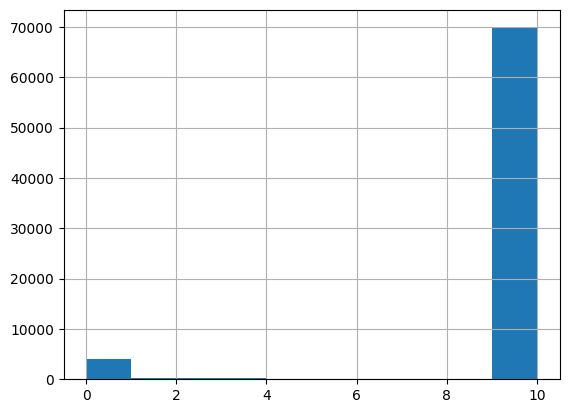

In [71]:
incidence['time_at_risk'].hist()

In [72]:
# Merge incidence data with train data
train_combined = train.merge(incidence[['IID', 'time_at_risk', 'event', 'case_type']], on='IID', how='left')

cox_train_data = train_combined[['time_at_risk', 'event'] + 
                                [col for col in train.columns if col not in ['label', 'case_type']]]


cox_train_data = cox_train_data.dropna()
cox_train_data.head()

,time_at_risk,event,IID,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,...,pca_aortic_embeddings_10,PRS,age,sex,bmi,ldl,trig,total_cholestrol,smoking,DM
0,10.001369,0.0,3267458,74.0,426.0,396.0,1146.0,1150.0,32.800000,529.166667,...,0.125697,-8.82705,61.0,1,20.5966,1.947,0.827,3.737,0.0,0
1,10.001369,0.0,4086644,90.0,418.0,438.0,914.0,905.0,45.200000,683.083333,...,0.110710,-7.71150,67.0,0,21.6128,2.917,1.406,5.806,1.0,0
2,0.001000,1.0,4236006,76.0,400.0,372.0,1152.0,1150.0,752.666667,714.000000,...,0.215217,-7.15006,65.0,1,23.9635,4.659,2.548,7.295,0.0,0
3,10.001369,0.0,2003477,92.0,442.0,422.0,1094.0,1090.0,65.500000,591.166667,...,0.022226,-8.02911,58.0,0,19.4213,2.249,0.815,4.011,0.0,0
4,10.001369,0.0,1817039,94.0,442.0,469.0,884.0,880.0,210.500000,504.583333,...,0.094858,-9.53054,69.0,0,21.0381,3.640,0.791,6.083,1.0,0


In [73]:
cox_train_data.to_csv('cox_train.csv', index = False)

In [78]:
# Process test data
test_combined = test.merge(incidence[['IID', 'MRI_date', 'earliest_diagnosis_date', 'case_type']], on='IID', how='left')

# Assign event_time for test data
test_combined['event_time'] = test_combined['earliest_diagnosis_date'].fillna(
    test_combined['MRI_date'] + pd.DateOffset(years=10)
)

# Calculate time_at_risk for test data
prevalent_cases_test = test_combined['case_type'] == 1
test_combined.loc[prevalent_cases_test, 'time_at_risk'] = 0.001  # Small positive value for prevalent cases
incident_or_controls_test = test_combined['case_type'] != 1
test_combined.loc[incident_or_controls_test, 'time_at_risk'] = (
    (test_combined['event_time'] - test_combined['MRI_date']).dt.days / 365.25
)

# Assign event indicator for test data
test_combined['event'] = test_combined['earliest_diagnosis_date'].notna().astype(int)

# Prepare test dataset for Cox modeling
cox_test_data = test_combined[['time_at_risk', 'event'] + 
                               [col for col in train.columns if col not in ['label', 'case_type']]]

In [79]:
cox_test_data.head()

,time_at_risk,event,IID,QRSDuration,QTInterval,QTCInterval,RRInterval,PPInterval,MeanQAmplitude,MeanRAmplitude,...,pca_aortic_embeddings_10,PRS,age,sex,bmi,ldl,trig,total_cholestrol,smoking,DM
0,10.001369,0,4890586,90.0,466.0,416.0,1238.0,1250.0,67.833333,874.750000,...,0.909180,-7.49033,54.0,1,28.8503,3.522,1.4984,6.487,1.0,0
1,10.001369,0,2201189,88.0,422.0,424.0,988.0,980.0,120.833333,801.083333,...,0.370246,-8.12347,71.0,1,25.4321,3.495,0.2062,5.995,0.0,0
2,0.394251,1,3646967,82.0,422.0,428.0,968.0,965.0,329.000000,356.416667,...,0.260463,-5.88483,72.0,1,30.2315,2.141,0.4210,3.422,0.0,0
3,10.001369,0,2032754,90.0,406.0,425.0,904.0,905.0,230.666667,472.416667,...,0.055522,-9.03647,58.0,0,41.5765,3.306,0.3804,5.408,1.0,0
4,1.095140,1,2434644,114.0,458.0,429.0,1140.0,1130.0,270.500000,1020.833333,...,0.061611,-8.19462,74.0,1,23.2438,2.620,0.2586,4.424,1.0,0


In [80]:
cox_test_data.to_csv('cox_test.csv', index = False)

**NEW METHOD**

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages

# Load train and test datasets
train_data = pd.read_csv('cox_train.csv')
test_data = pd.read_csv('cox_test.csv')

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
heart_imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Select numeric features for scaling (exclude categorical features like smoking and sex)
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + heart_imaging_features

# Apply StandardScaler
scaler = StandardScaler()
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])
test_data[features_to_scale] = scaler.transform(test_data[features_to_scale])

# Fit Cox model on full train dataset
cph = CoxPHFitter()
cph.fit(train_data[baseline_features + metabolic_features + PRS + heart_imaging_features + ['time_at_risk', 'event']], 
        duration_col='time_at_risk', event_col='event')

# Predict risk score for test data
test_data['risk_score'] = cph.predict_partial_hazard(test_data)

# Variables to be binned (including categorical ones)
bin_vars = ['PRS', 'age', 'bmi', 'ldl', 'total_cholestrol']
cat_vars = ['sex', 'smoking']  # Categorical variables

# Bin continuous variables into three groups (Low, Medium, High)
for var in bin_vars:
    test_data[f'{var}_bin'] = pd.qcut(test_data[var], q=3, labels=['Low', 'Medium', 'High'])

# Convert categorical variables to meaningful string labels
test_data['sex_bin'] = test_data['sex'].map({0: 'Female', 1: 'Male'})  # Correct encoding for sex
test_data['smoking_bin'] = test_data['smoking'].map({
    0: 'Never', 
    1: 'Previous', 
    2: 'Current'
})  # Excludes "-3: Prefer not to answer"

# Remove "Prefer not to answer" smoking entries
test_data = test_data[test_data['smoking'] != -3].copy()

# Function to plot Kaplan-Meier survival curves
def plot_km_curve(df, variable, pdf, duration_col='time_at_risk', event_col='event'):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6))

    categories = sorted(df[f'{variable}_bin'].dropna().unique())  # Ensure no missing values
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        kmf.fit(subset[duration_col], event_observed=subset[event_col], label=f'{variable} {category}')
        kmf.plot_survival_function()

    plt.xlabel('Time at Risk')
    plt.ylabel('Survival Probability')
    plt.title(f'Kaplan-Meier Survival Curves by {variable}')
    plt.legend()
    plt.grid(True)

    # Save figure to PDF
    pdf.savefig()
    plt.close()

# Function to compute log-rank test p-values
def compute_log_rank_pvalues(df, variable, duration_col='time_at_risk', event_col='event'):
    categories = sorted(df[f'{variable}_bin'].dropna().unique())  # Ensure valid categories
    p_values = {}

    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                group1 = df[df[f'{variable}_bin'] == cat1]
                group2 = df[df[f'{variable}_bin'] == cat2]
                result = logrank_test(group1[duration_col], group2[duration_col], 
                                      event_observed_A=group1[event_col], event_observed_B=group2[event_col])
                p_values[f"{cat1} vs {cat2}"] = result.p_value

    return p_values

# Save all Kaplan-Meier plots and p-values table into a single PDF
pdf_filename = "KaplanMeier_Plots_and_PValues.pdf"
with PdfPages(pdf_filename) as pdf:
    # Generate plots for continuous variables
    for var in bin_vars:
        plot_km_curve(test_data, var, pdf)

    # Generate plots for categorical variables
    for var in cat_vars:
        plot_km_curve(test_data, var, pdf)

    # Compute log-rank test p-values and save to PDF
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Generate p-values for all variables
    pval_dict = {}
    for var in bin_vars + cat_vars:
        pval_dict[var] = compute_log_rank_pvalues(test_data, var)

    # Convert p-values to a table format
    table_data = []
    for var, comparisons in pval_dict.items():
        for comparison, p_val in comparisons.items():
            table_data.append([var, comparison, f"{p_val:.4e}"])  # Format as scientific notation

    # Convert to DataFrame for visualization
    pval_df = pd.DataFrame(table_data, columns=['Variable', 'Comparison', 'Log-Rank P-Value'])

    # Plot table
    table = ax.table(cellText=pval_df.values, colLabels=pval_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([0, 1, 2])

    pdf.savefig(fig)  # Save p-value table to PDF
    plt.close()

print(f"All Kaplan-Meier plots and log-rank p-values saved in {pdf_filename}")

All Kaplan-Meier plots and log-rank p-values saved in KaplanMeier_Plots_and_PValues.pdf


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages

# Load train and test datasets
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Load XGBoost predictions and merge with cox_test on IID
results_test_df = pd.read_csv('results_test_df.csv')
cox_test = cox_test.merge(results_test_df[['IID', 'Pred_Proba']], on='IID', how='left')

# Convert follow-up time from years to days
cox_train['time_at_risk'] *= 365
cox_test['time_at_risk'] *= 365

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
heart_imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Select numeric features for scaling
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + heart_imaging_features

# Apply StandardScaler
scaler = StandardScaler()
cox_train[features_to_scale] = scaler.fit_transform(cox_train[features_to_scale])
cox_test[features_to_scale] = scaler.transform(cox_test[features_to_scale])

# Fit Cox model on full train dataset
cph = CoxPHFitter()
cph.fit(cox_train[baseline_features + metabolic_features + PRS + heart_imaging_features + ['time_at_risk', 'event']], 
        duration_col='time_at_risk', event_col='event')

# Predict risk score for test data
cox_test['cox_risk_score'] = cph.predict_partial_hazard(cox_test)

# Variables to be binned (continuous)
bin_vars = ['PRS', 'age', 'bmi', 'ldl', 'total_cholestrol', 'Pred_Proba']
cat_vars = ['sex', 'smoking']  # Categorical variables

# Bin continuous variables into three groups (Low, Medium, High)
for var in bin_vars:
    cox_test[f'{var}_bin'] = pd.qcut(cox_test[var], q=3, labels=['Low', 'Medium', 'High'])

# Convert categorical variables to meaningful labels
cox_test['sex_bin'] = cox_test['sex'].map({0: 'Female', 1: 'Male'})
cox_test['smoking_bin'] = cox_test['smoking'].map({0: 'Never', 1: 'Previous', 2: 'Current'})

# Remove "Prefer not to answer" smoking entries
cox_test = cox_test[cox_test['smoking'] != -3].copy()

# Define color mappings for both continuous and categorical variables
colors = {
    'Low': 'green', 'Medium': 'yellow', 'High': 'brown',
    'Female': 'blue', 'Male': 'red',
    'Never': 'purple', 'Previous': 'orange', 'Current': 'black'
}

# Function to plot cumulative hazard using Nelson-Aalen estimator
def plot_nelson_aalen_cumulative_hazard(df, variable, pdf, duration_col='time_at_risk', event_col='event'):
    naf = NelsonAalenFitter()
    plt.figure(figsize=(8, 6))

    # Handle categorical vs. continuous variables
    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    risk_table = []

    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        naf.fit(subset[duration_col], event_observed=subset[event_col], label=f'{variable} {category}')
        naf.plot(color=colors[category])

        # Convert time axis from days to years
        plt.xticks(ticks=plt.xticks()[0], labels=[f"{int(t/365)}" for t in plt.xticks()[0]])

        # Get number at risk at key time points (converted to years)
        time_points = np.linspace(0, max(df[duration_col]), num=5, dtype=int)
        num_at_risk = [subset[subset[duration_col] >= t].shape[0] for t in time_points]
        risk_table.append(num_at_risk)

    plt.xlabel('Follow-up Time (years)')
    plt.ylabel('Cumulative Hazard')
    plt.title(f'Cumulative Hazard by {variable}')
    plt.legend()
    plt.grid(True)

    # Add "Number at risk" table below plot
    ax = plt.gca()
    table = ax.table(cellText=risk_table, rowLabels=categories, colLabels=[f"{int(t/365)}" for t in time_points],
                     loc='bottom', cellLoc='center', bbox=[0, -0.3, 1, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Save figure to PDF
    pdf.savefig()
    plt.close()

# Function to compute log-rank test p-values
def compute_log_rank_pvalues(df, variable, duration_col='time_at_risk', event_col='event'):
    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    p_values = {}

    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                group1 = df[df[f'{variable}_bin'] == cat1]
                group2 = df[df[f'{variable}_bin'] == cat2]
                result = logrank_test(group1[duration_col], group2[duration_col], 
                                      event_observed_A=group1[event_col], event_observed_B=group2[event_col])
                p_values[f"{cat1} vs {cat2}"] = result.p_value

    return p_values

# Save cumulative hazard plots and p-values table into a single PDF
pdf_filename = "Cox_Cumulative_Hazard_Plots.pdf"
with PdfPages(pdf_filename) as pdf:
    # Generate plots for continuous variables
    for var in bin_vars:
        plot_nelson_aalen_cumulative_hazard(cox_test, var, pdf)

    # Generate plots for categorical variables
    for var in cat_vars:
        plot_nelson_aalen_cumulative_hazard(cox_test, var, pdf)

    # Compute log-rank test p-values and save to PDF
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Generate p-values for all variables
    pval_dict = {}
    for var in bin_vars + cat_vars:
        pval_dict[var] = compute_log_rank_pvalues(cox_test, var)

    # Convert p-values to a table format
    table_data = []
    for var, comparisons in pval_dict.items():
        for comparison, p_val in comparisons.items():
            table_data.append([var, comparison, f"{p_val:.6f}"])  # Standard decimal format

    # Convert to DataFrame for visualization
    pval_df = pd.DataFrame(table_data, columns=['Variable', 'Comparison', 'Log-Rank P-Value'])

    # Plot table
    table = ax.table(cellText=pval_df.values, colLabels=pval_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    pdf.savefig(fig)
    plt.close()

print(f"All cumulative hazard plots and log-rank p-values saved in {pdf_filename}")


All cumulative hazard plots and log-rank p-values saved in Cox_Cumulative_Hazard_Plots.pdf


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages

# Load train and test datasets
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Load XGBoost predictions and merge with cox_test on IID
results_test_df = pd.read_csv('results_test_df.csv')
cox_test = cox_test.merge(results_test_df[['IID', 'Pred_Proba']], on='IID', how='left')

# Convert follow-up time from years to days
cox_train['time_at_risk'] *= 365
cox_test['time_at_risk'] *= 365

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']

# Imaging Features (Combined: Long-Axis + Aortic Distensibility)
imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Select numeric features for scaling
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + imaging_features

# Apply StandardScaler
scaler = StandardScaler()
cox_train[features_to_scale] = scaler.fit_transform(cox_train[features_to_scale])
cox_test[features_to_scale] = scaler.transform(cox_test[features_to_scale])

# Fit Cox model on full train dataset using baseline and PRS
cph = CoxPHFitter()
cph.fit(cox_train[baseline_features + metabolic_features + PRS + ['time_at_risk', 'event']], 
        duration_col='time_at_risk', event_col='event')

# Predict risk score for test data
cox_test['cox_risk_score'] = cph.predict_partial_hazard(cox_test)

# Bin PRS into "Low", "Medium", "High"
cox_test['PRS_bin'] = pd.qcut(cox_test['PRS'], q=3, labels=['Low', 'Medium', 'High'])

# **STEP 1: Select High-PRS Individuals**
high_prs_group = cox_test[cox_test['PRS_bin'] == 'High'].copy()

# **STEP 2: Fit Cox Model Using Combined Imaging Features**
cph_imaging = CoxPHFitter()
cph_imaging.fit(high_prs_group[imaging_features + ['time_at_risk', 'event']], 
                duration_col='time_at_risk', event_col='event')

# **STEP 3: Predict Imaging-Based Risk Scores**
high_prs_group['imaging_risk_score'] = cph_imaging.predict_partial_hazard(high_prs_group)

# **STEP 4: Bin Individuals by Imaging Risk**
high_prs_group['imaging_risk_bin'] = pd.qcut(high_prs_group['imaging_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# **STEP 5: Generate Kaplan-Meier and Cumulative Hazard Plots**
def plot_survival_curves(df, variable, pdf):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6))

    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{variable} {category}')
        kmf.plot_survival_function()

    plt.xlabel('Follow-up Time (years)')
    plt.ylabel('Survival Probability')
    plt.title(f'Kaplan-Meier Survival Curves by {variable}')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

def plot_cumulative_hazard(df, variable, pdf):
    naf = NelsonAalenFitter()
    plt.figure(figsize=(8, 6))

    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        naf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{variable} {category}')
        naf.plot()

    plt.xlabel('Follow-up Time (years)')
    plt.ylabel('Cumulative Hazard')
    plt.title(f'Cumulative Hazard by {variable}')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

# **STEP 6: Save Plots and Explanation to PDF**
pdf_filename = "High_PRS_Combined_Imaging_Cox_Analysis.pdf"
with PdfPages(pdf_filename) as pdf:
    # Write Explanation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    explanation = (
        "This analysis examines whether imaging features can further stratify individuals at high PRS risk. "
        "We first identified individuals in the highest PRS tertile. We then fit a Cox model incorporating all imaging features, "
        "including long-axis imaging (heart motion and structure) and aortic distensibility (vascular function). "
        "Survival and cumulative hazard plots are generated to assess the predictive value of these features."
    )
    ax.text(0.1, 0.5, explanation, fontsize=12, wrap=True)
    pdf.savefig(fig)
    plt.close()

    # Generate plots for Combined Imaging Risk
    plot_survival_curves(high_prs_group, 'imaging_risk', pdf)
    plot_cumulative_hazard(high_prs_group, 'imaging_risk', pdf)

print(f"All high-PRS imaging risk stratification results saved in {pdf_filename}")

All high-PRS imaging risk stratification results saved in High_PRS_Combined_Imaging_Cox_Analysis.pdf


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_pdf import PdfPages

# Load train and test datasets
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Load XGBoost predictions and merge with cox_test on IID
results_test_df = pd.read_csv('results_test_df.csv')
cox_test = cox_test.merge(results_test_df[['IID', 'Pred_Proba']], on='IID', how='left')

# Convert follow-up time from years to days
cox_train['time_at_risk'] *= 365
cox_test['time_at_risk'] *= 365

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']

# Imaging Features (Combined: Long-Axis + Aortic Distensibility)
imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Select numeric features for scaling
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'trig', 'PRS'] + imaging_features

# Apply StandardScaler
scaler = StandardScaler()
cox_train[features_to_scale] = scaler.fit_transform(cox_train[features_to_scale])
cox_test[features_to_scale] = scaler.transform(cox_test[features_to_scale])

# Fit Cox model on full train dataset using baseline and PRS
cph = CoxPHFitter()
cph.fit(cox_train[baseline_features + metabolic_features + PRS + ['time_at_risk', 'event']], 
        duration_col='time_at_risk', event_col='event')

# Predict risk score for test data
cox_test['cox_risk_score'] = cph.predict_partial_hazard(cox_test)

# Bin PRS and Lipids into "Low", "Medium", "High"
cox_test['PRS_bin'] = pd.qcut(cox_test['PRS'], q=3, labels=['Low', 'Medium', 'High'])
cox_test['LDL_bin'] = pd.qcut(cox_test['ldl'], q=3, labels=['Low', 'Medium', 'High'])
cox_test['TotalChol_bin'] = pd.qcut(cox_test['total_cholestrol'], q=3, labels=['Low', 'Medium', 'High'])
cox_test['Trig_bin'] = pd.qcut(cox_test['trig'], q=3, labels=['Low', 'Medium', 'High'])

# **STEP 1: Select Individuals with High PRS OR High Lipids**
high_prs_or_lipids_group = cox_test[
    (cox_test['PRS_bin'] == 'High') | 
    (cox_test['LDL_bin'] == 'High') | 
    (cox_test['TotalChol_bin'] == 'High') | 
    (cox_test['Trig_bin'] == 'High')
].copy()

# **STEP 2: Fit Cox Model Using Combined Imaging Features**
cph_imaging = CoxPHFitter()
cph_imaging.fit(high_prs_or_lipids_group[imaging_features + ['time_at_risk', 'event']], 
                duration_col='time_at_risk', event_col='event')

# **STEP 3: Predict Imaging-Based Risk Scores**
high_prs_or_lipids_group['imaging_risk_score'] = cph_imaging.predict_partial_hazard(high_prs_or_lipids_group)

# **STEP 4: Bin Individuals by Imaging Risk**
high_prs_or_lipids_group['imaging_risk_bin'] = pd.qcut(high_prs_or_lipids_group['imaging_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# **STEP 5: Generate Kaplan-Meier and Cumulative Hazard Plots**
def plot_survival_curves(df, variable, pdf):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6))

    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{variable} {category}')
        kmf.plot_survival_function()

    plt.xlabel('Follow-up Time (years)')
    plt.ylabel('Survival Probability')
    plt.title(f'Kaplan-Meier Survival Curves by {variable}')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

def plot_cumulative_hazard(df, variable, pdf):
    naf = NelsonAalenFitter()
    plt.figure(figsize=(8, 6))

    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        naf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{variable} {category}')
        naf.plot()

    plt.xlabel('Follow-up Time (years)')
    plt.ylabel('Cumulative Hazard')
    plt.title(f'Cumulative Hazard by {variable}')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

# **STEP 6: Save Plots and Explanation to PDF**
pdf_filename = "High_PRS_Lipids_Imaging_Cox_Analysis.pdf"
with PdfPages(pdf_filename) as pdf:
    # Write Explanation
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    explanation = (
        "This analysis examines whether imaging features can further stratify individuals at high risk based on PRS or lipid levels. "
        "We first identified individuals in the highest tertile for PRS, LDL, total cholesterol, or triglycerides. "
        "We then fit a Cox model incorporating all imaging features to create an imaging risk score. "
        "Survival and cumulative hazard plots are generated to assess the predictive value of imaging for these high-risk individuals."
    )
    ax.text(0.1, 0.5, explanation, fontsize=12, wrap=True)
    pdf.savefig(fig)
    plt.close()

    # Generate plots for Combined Imaging Risk
    plot_survival_curves(high_prs_or_lipids_group, 'imaging_risk', pdf)
    plot_cumulative_hazard(high_prs_or_lipids_group, 'imaging_risk', pdf)

print(f"All high-PRS or high-lipid imaging risk stratification results saved in {pdf_filename}")


All high-PRS or high-lipid imaging risk stratification results saved in High_PRS_Lipids_Imaging_Cox_Analysis.pdf


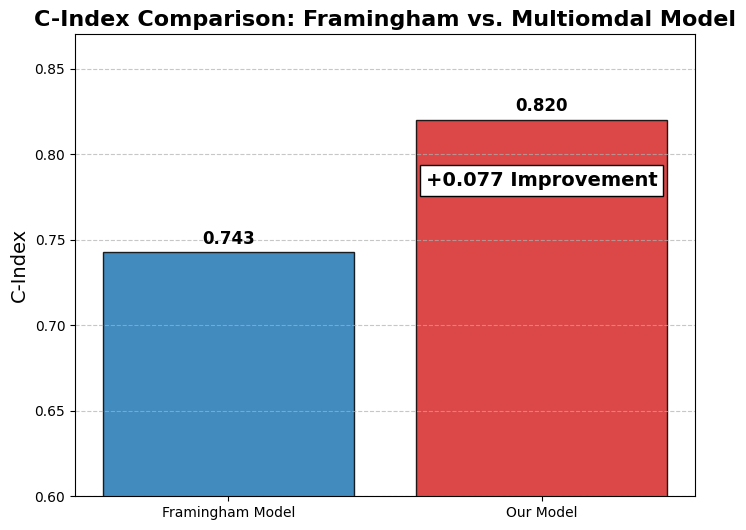

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

# Load train and test datasets
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
heart_imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Define Framingham Model Features
fram_cols = ['age', 'sex', 'bmi', 'ldl', 'total_cholestrol', 'smoking', 'DM']

# Define Your Model Features
your_model_features = baseline_features + metabolic_features + PRS + heart_imaging_features

# Select numeric features for scaling
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + heart_imaging_features

# Apply StandardScaler
scaler = StandardScaler()
cox_train[features_to_scale] = scaler.fit_transform(cox_train[features_to_scale])
cox_test[features_to_scale] = scaler.transform(cox_test[features_to_scale])

# Fit Framingham Model
cph_fram = CoxPHFitter()
cph_fram.fit(cox_train[fram_cols + ['time_at_risk', 'event']], duration_col='time_at_risk', event_col='event')

# Fit Your Model
cph_your_model = CoxPHFitter()
cph_your_model.fit(cox_train[your_model_features + ['time_at_risk', 'event']], duration_col='time_at_risk', event_col='event')

# Compute Test C-Index for Both Models
c_index_fram = cph_fram.concordance_index_
c_index_your_model = cph_your_model.concordance_index_

# Compute Improvement
c_index_diff = c_index_your_model - c_index_fram

# Plot Settings
plt.figure(figsize=(8, 6))

# Models and their C-Indices
models = ['Framingham Model', 'Our Model']
c_indices = [c_index_fram, c_index_your_model]
colors = ['#1f77b4', '#d62728']  # Professional color scheme

# Bar Plot
bars = plt.bar(models, c_indices, color=colors, alpha=0.85, edgecolor='black')

# Add value labels on bars
for bar, c_index in zip(bars, c_indices):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
             f"{c_index:.3f}", ha='center', fontsize=12, fontweight='bold')

# Highlight C-Index Improvement
plt.text(1, (c_index_fram + c_index_your_model) / 2, 
         f"+{c_index_diff:.3f} Improvement", 
         fontsize=14, fontweight='bold', ha='center', color='black', bbox=dict(facecolor='white', edgecolor='black'))

# Titles and Labels
plt.ylabel('C-Index', fontsize=14)
plt.title('C-Index Comparison: Framingham vs. Multiomdal Model', fontsize=16, fontweight='bold')
plt.ylim(0.6, max(c_indices) + 0.05)  # Adjust Y-axis range for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the Plot
plt.show()

In [4]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

# Load train dataset
train_data = pd.read_csv('cox_train.csv')
test_data = pd.read_csv('cox_test.csv')

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']  # Includes Diabetes
PRS = ['PRS']
heart_imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Function to compute cross-validated C-index and confidence intervals
def compute_c_index_with_cv(data, features, duration_col='time_at_risk', event_col='event', n_splits=5):
    cph = CoxPHFitter()
    c_indexes = []
    
    # KFold Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(data):
        train_fold = data.iloc[train_idx]
        val_fold = data.iloc[val_idx]
        
        cph.fit(train_fold[features + [duration_col, event_col]], duration_col=duration_col, event_col=event_col)
        c_index = cph.score(val_fold[features + [duration_col, event_col]], scoring_method="concordance_index")
        c_indexes.append(c_index)
    
    mean_c_index = np.mean(c_indexes)
    std_c_index = np.std(c_indexes)
    lower_ci = mean_c_index - 1.96 * std_c_index / np.sqrt(n_splits)  # 95% CI lower bound
    upper_ci = mean_c_index + 1.96 * std_c_index / np.sqrt(n_splits)  # 95% CI upper bound
    return mean_c_index, lower_ci, upper_ci

# Sequential model building
steps = [
    ("Framingham Model", baseline_features + metabolic_features),
    ("+ PRS", baseline_features + metabolic_features + PRS),
    ("+ Heart Imaging", baseline_features + metabolic_features + PRS + heart_imaging_features),
]

results = []
for step_name, features in steps:
    c_index, lower_ci, upper_ci = compute_c_index_with_cv(train_data, features)
    results.append((step_name, c_index, lower_ci, upper_ci))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Step', 'C-Index', 'Lower CI', 'Upper CI'])

# Calculate relative gains
results_df['Relative Gain (%)'] = results_df['C-Index'].pct_change() * 100

In [5]:
results_df

,Step,C-Index,Lower CI,Upper CI,Relative Gain (%)
0,Framingham Model,0.745185,0.732956,0.757414,NaN
1,+ PRS,0.772063,0.759378,0.784748,3.606857
2,+ Heart Imaging,0.813667,0.798726,0.828608,5.388679


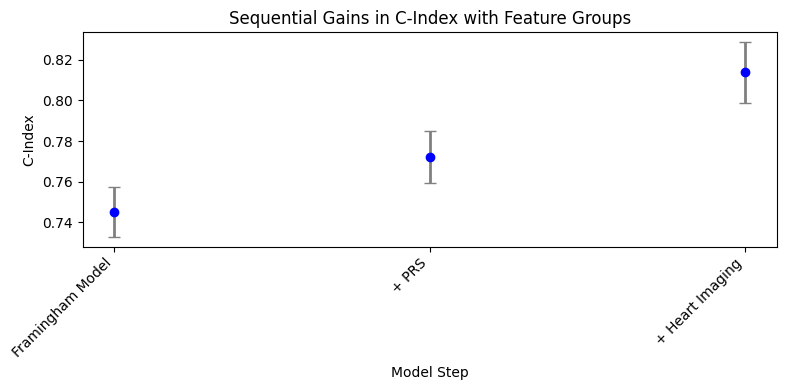

In [7]:
# Plot C-Index with error bars
plt.figure(figsize=(8, 4))
plt.errorbar(
    results_df['Step'],
    results_df['C-Index'],
    yerr=[results_df['C-Index'] - results_df['Lower CI'], results_df['Upper CI'] - results_df['C-Index']],
    fmt='o',
    color='blue',
    ecolor='gray',
    elinewidth=2,
    capsize=4
)
plt.xlabel('Model Step')
plt.ylabel('C-Index')
plt.title('Sequential Gains in C-Index with Feature Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_3847865/3296928061.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Step', y='C-Index', data=results_df, palette=[sns.set_hls_values(color, l=0.6) for color in palette], width=0.5, linewidth=2.5)
/tmp/ipykernel_3847865/3296928061.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Step', y='C-Index', data=results_df, palette=[sns.set_hls_values(color, l=0.3) for color in palette], jitter=True, size=8, alpha=0.8)


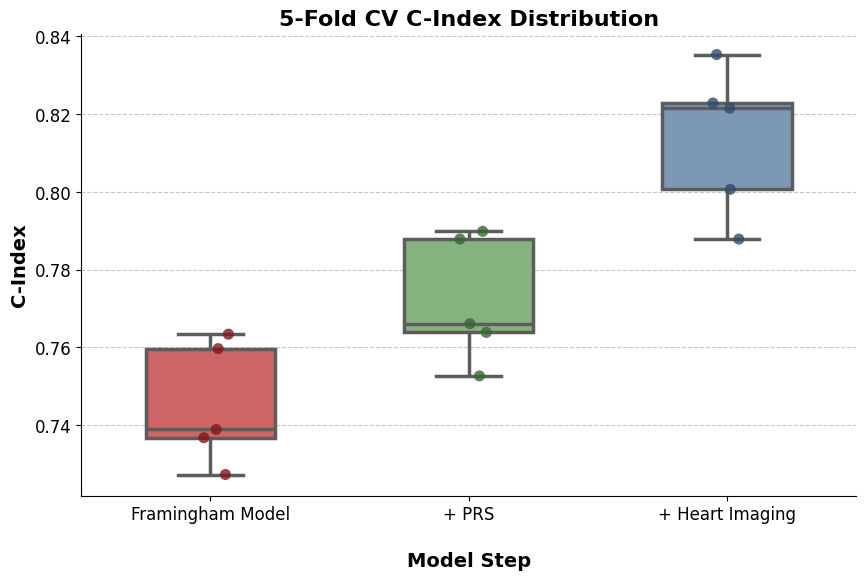

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Load train dataset
train_data = pd.read_csv('cox_train.csv')

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
heart_imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Function to compute cross-validated C-index
def compute_c_index_with_cv(data, features, duration_col='time_at_risk', event_col='event', n_splits=5):
    cph = CoxPHFitter()
    c_indexes = []
    
    # KFold Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(data):
        train_fold = data.iloc[train_idx]
        val_fold = data.iloc[val_idx]
        
        cph.fit(train_fold[features + [duration_col, event_col]], duration_col=duration_col, event_col=event_col)
        c_index = cph.score(val_fold[features + [duration_col, event_col]], scoring_method="concordance_index")
        c_indexes.append(c_index)
    
    return c_indexes

# Sequential model building
steps = [
    ("Framingham Model", baseline_features + metabolic_features),
    ("+ PRS", baseline_features + metabolic_features + PRS),
    ("+ Heart Imaging", baseline_features + metabolic_features + PRS + heart_imaging_features),
]

results = []
for step_name, features in steps:
    c_indexes = compute_c_index_with_cv(train_data, features)
    for c_index in c_indexes:
        results.append((step_name, c_index))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Step', 'C-Index'])

# Define an improved color-blind friendly palette
palette = ["#E15759", "#59A14F", "#4E79A7"]  # Orange, Blue, Green for distinct contrast

# Apply enhanced typography settings
plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 12})

# Create aesthetically enhanced boxplot with jitter for 5-fold CV C-Index
plt.figure(figsize=(10, 6))
sns.boxplot(x='Step', y='C-Index', data=results_df, palette=[sns.set_hls_values(color, l=0.6) for color in palette], width=0.5, linewidth=2.5)
sns.stripplot(x='Step', y='C-Index', data=results_df, palette=[sns.set_hls_values(color, l=0.3) for color in palette], jitter=True, size=8, alpha=0.8)
plt.title("5-Fold CV C-Index Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Model Step", fontsize=14, fontweight='bold', labelpad=20)
plt.ylabel("C-Index", fontsize=14, fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

# Save plot as PDF
plt.savefig("cv_c_index_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

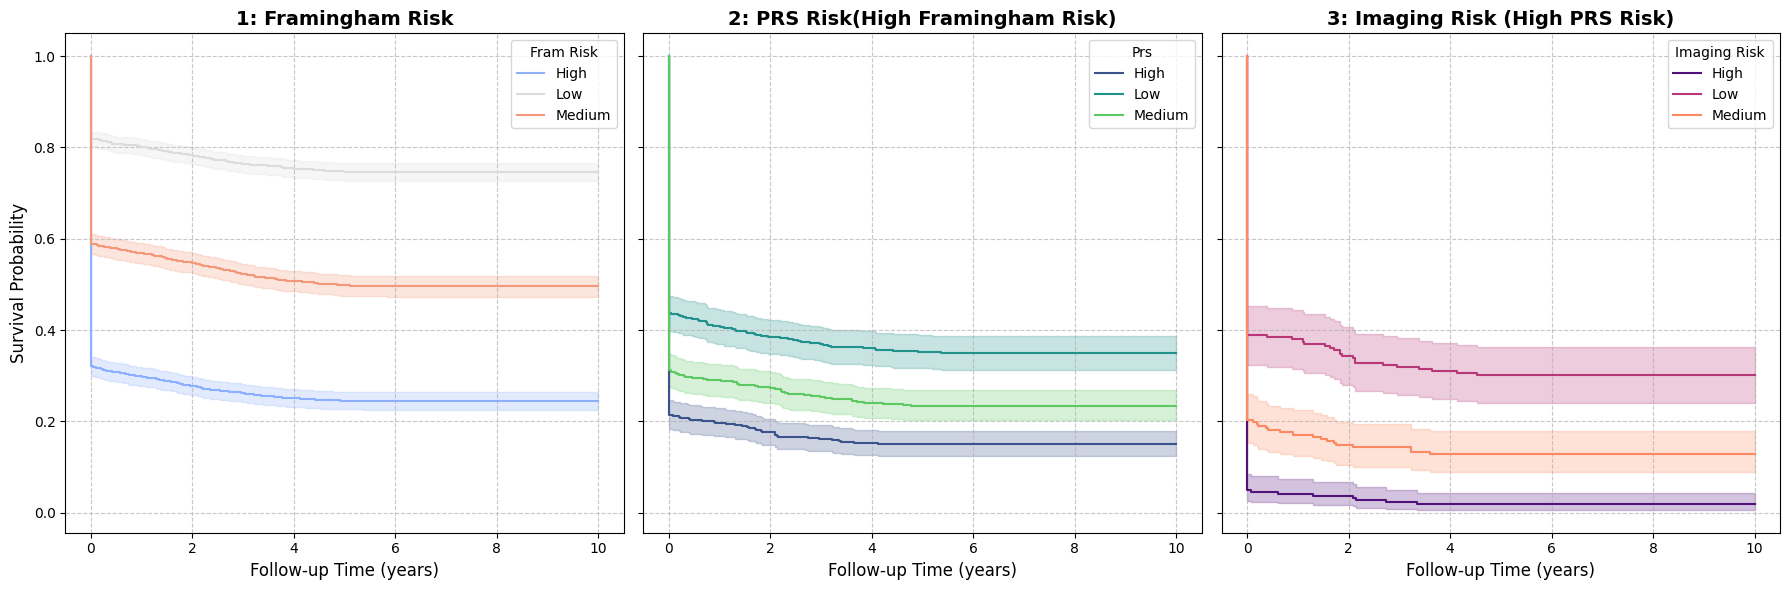

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import StandardScaler

# Load train dataset
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Combine train and test data for better stratification
cox_data = pd.concat([cox_train, cox_test], ignore_index=True)

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Apply StandardScaler
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + imaging_features
scaler = StandardScaler()
cox_data[features_to_scale] = scaler.fit_transform(cox_data[features_to_scale])

# Fit Cox model using Framingham features
cph_fram = CoxPHFitter()
cph_fram.fit(cox_data[baseline_features + metabolic_features + ['time_at_risk', 'event']], 
             duration_col='time_at_risk', event_col='event')
cox_data['fram_risk_score'] = cph_fram.predict_partial_hazard(cox_data)

# Stratify by Framingham risk tertiles
cox_data['fram_risk_bin'] = pd.qcut(cox_data['fram_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# Select individuals with **High** Framingham risk
fram_high_risk = cox_data[cox_data['fram_risk_bin'] == 'High'].copy()
fram_high_risk['PRS_bin'] = pd.qcut(fram_high_risk['PRS'], q=3, labels=['Low', 'Medium', 'High'])

# Select individuals with **High** PRS risk
prs_high_risk = fram_high_risk[fram_high_risk['PRS_bin'] == 'High'].copy()

# Fit Cox model for imaging features
cph_imaging = CoxPHFitter()
cph_imaging.fit(prs_high_risk[imaging_features + ['time_at_risk', 'event']], 
                duration_col='time_at_risk', event_col='event')
prs_high_risk['imaging_risk_score'] = cph_imaging.predict_partial_hazard(prs_high_risk)

# Stratify by imaging risk tertiles
prs_high_risk['imaging_risk_bin'] = pd.qcut(prs_high_risk['imaging_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# Function to plot survival curves side by side
def plot_survival_comparison(dfs, variables, titles, colors):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for ax, df, variable, title, color_palette in zip(axes, dfs, variables, titles, colors):
        kmf = KaplanMeierFitter()
        categories = sorted(df[f'{variable}_bin'].dropna().unique())

        for category, color in zip(categories, color_palette):
            subset = df[df[f'{variable}_bin'] == category]
            kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{category}')
            kmf.plot_survival_function(ax=ax, ci_show=True, color=color)

        ax.set_xlabel('Follow-up Time (years)', fontsize=12)
        ax.set_ylabel('Survival Probability', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(title=variable.replace('_', ' ').title(), fontsize=10, loc='best')
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Define color palettes
fram_colors = sns.color_palette("coolwarm", 3)  # Tertiles: 3 colors
prs_colors = sns.color_palette("viridis", 3)  
imaging_colors = sns.color_palette("magma", 3)  

# Plot survival curves for all three stratifications side by side
plot_survival_comparison(
    [cox_data, fram_high_risk, prs_high_risk],
    ['fram_risk', 'PRS', 'imaging_risk'],
    ['1: Framingham Risk', '2: PRS Risk(High Framingham Risk)', 
     '3: Imaging Risk (High PRS Risk)'],
    [fram_colors, prs_colors, imaging_colors]
)


/work/07880/devansh/anaconda3/envs/pyt_env/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


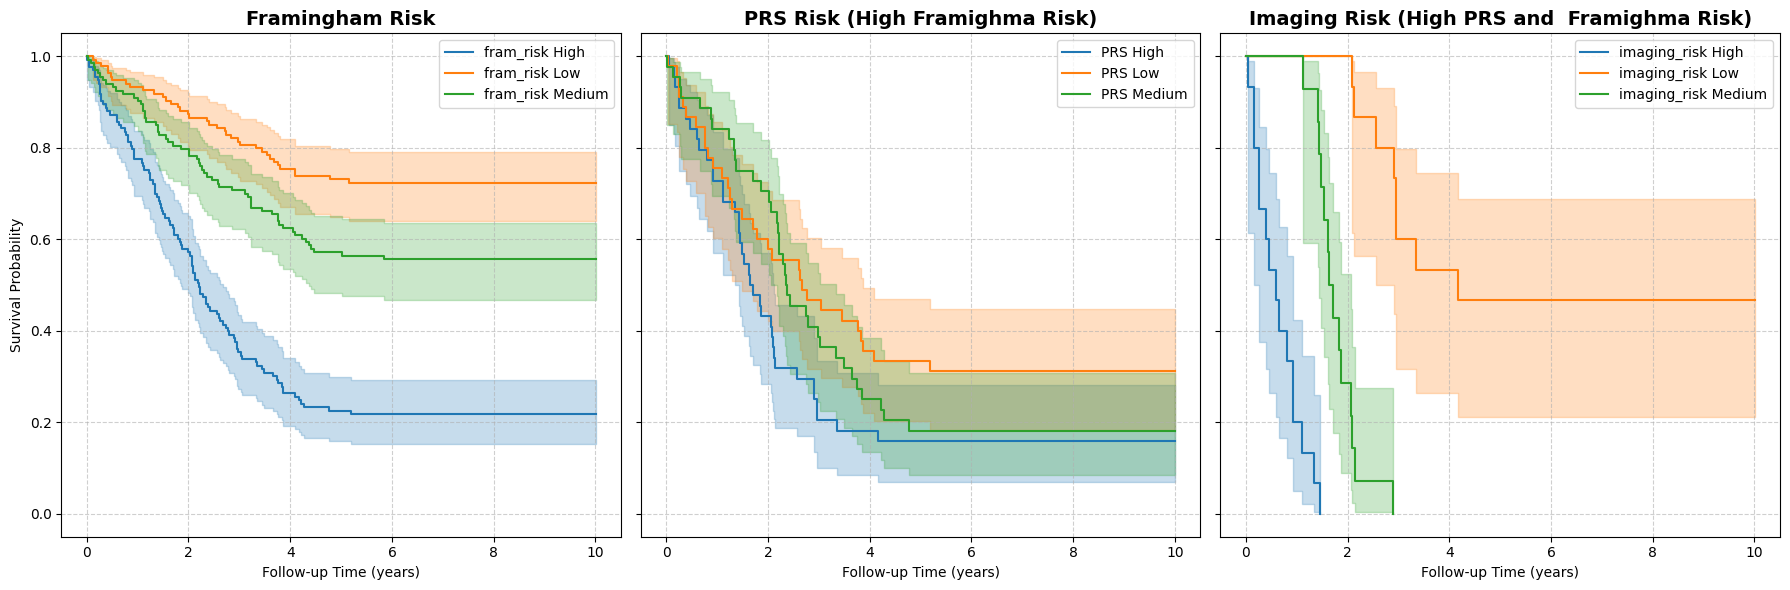

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import StandardScaler

# Load test dataset
cox_test = pd.read_csv('cox_test.csv')

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Apply StandardScaler
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + imaging_features
scaler = StandardScaler()
cox_test[features_to_scale] = scaler.fit_transform(cox_test[features_to_scale])

# Fit Cox model using Framingham features
cph_fram = CoxPHFitter()
cph_fram.fit(cox_test[baseline_features + metabolic_features + ['time_at_risk', 'event']], 
             duration_col='time_at_risk', event_col='event')
cox_test['fram_risk_score'] = cph_fram.predict_partial_hazard(cox_test)

# Stratify by Framingham risk tertiles
cox_test['fram_risk_bin'] = pd.qcut(cox_test['fram_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# Select high-risk individuals by Framingham
high_fram_group = cox_test[cox_test['fram_risk_bin'] == 'High'].copy()

# Stratify high-risk group by PRS
high_fram_group['PRS_bin'] = pd.qcut(high_fram_group['PRS'], q=3, labels=['Low', 'Medium', 'High'])

# Select high PRS individuals
high_prs_group = high_fram_group[high_fram_group['PRS_bin'] == 'High'].copy()

# Fit Cox model using imaging features in high PRS group
cph_imaging = CoxPHFitter()
cph_imaging.fit(high_prs_group[imaging_features + ['time_at_risk', 'event']], 
                duration_col='time_at_risk', event_col='event')

# Predict imaging-based risk score
high_prs_group['imaging_risk_score'] = cph_imaging.predict_partial_hazard(high_prs_group)

# Stratify by imaging risk tertiles
high_prs_group['imaging_risk_bin'] = pd.qcut(high_prs_group['imaging_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# Function to plot survival curves
def plot_survival_curves(df, variable, title, ax):
    kmf = KaplanMeierFitter()
    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{variable} {category}')
        kmf.plot_survival_function(ax=ax)
    ax.set_xlabel('Follow-up Time (years)')
    ax.set_ylabel('Survival Probability')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Create side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_survival_curves(cox_test, 'fram_risk', 'Framingham Risk', axes[0])
plot_survival_curves(high_fram_group, 'PRS', 'PRS Risk (High Framighma Risk)', axes[1])
plot_survival_curves(high_prs_group, 'imaging_risk', 'Imaging Risk (High PRS and  Framighma Risk)', axes[2])

plt.tight_layout()
plt.show()


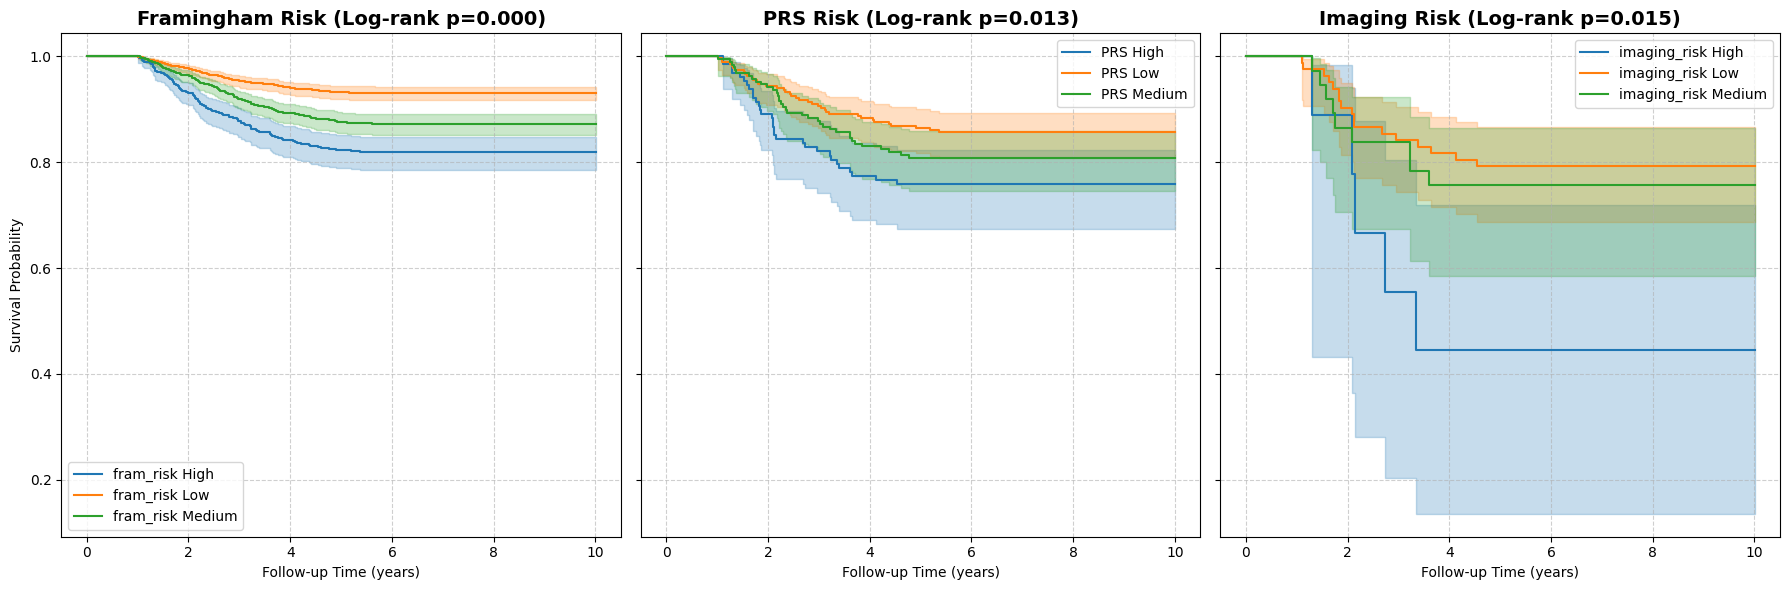

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import StandardScaler

# Load train and test datasets
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')

# Combine train and test datasets
cox_data = pd.concat([cox_train, cox_test], ignore_index=True)

# Define feature groups
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']
PRS = ['PRS']
imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)]
    + [f'pca_embedding1_{i}' for i in range(1, 11)]
    + [f'pca_embedding2_{i}' for i in range(1, 11)]
    + [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

# Apply StandardScaler
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol', 'PRS'] + imaging_features
scaler = StandardScaler()
cox_data[features_to_scale] = scaler.fit_transform(cox_data[features_to_scale])

# Fit Cox model using Framingham features
cph_fram = CoxPHFitter()
cph_fram.fit(cox_data[baseline_features + metabolic_features + ['time_at_risk', 'event']], 
             duration_col='time_at_risk', event_col='event')
cox_data['fram_risk_score'] = cph_fram.predict_partial_hazard(cox_data)

# Stratify by Framingham risk tertiles
cox_data['fram_risk_bin'] = pd.qcut(cox_data['fram_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# Select high-risk individuals by Framingham
high_fram_group = cox_data[cox_data['fram_risk_bin'] == 'High'].copy()

# Stratify high-risk group by PRS
high_fram_group['PRS_bin'] = pd.qcut(high_fram_group['PRS'], q=3, labels=['Low', 'Medium', 'High'])

# Select high PRS individuals
high_prs_group = high_fram_group[high_fram_group['PRS_bin'] == 'High'].copy()

# Fit Cox model using imaging features in high PRS group
cph_imaging = CoxPHFitter()
cph_imaging.fit(high_prs_group[imaging_features + ['time_at_risk', 'event']], 
                duration_col='time_at_risk', event_col='event')

# Predict imaging-based risk score
high_prs_group['imaging_risk_score'] = cph_imaging.predict_partial_hazard(high_prs_group)

# Stratify by imaging risk tertiles
high_prs_group['imaging_risk_bin'] = pd.qcut(high_prs_group['imaging_risk_score'], q=3, labels=['Low', 'Medium', 'High'])

# Include all event = 0 data, but keep event = 1 only for time_at_risk >= 1 year (avoid bias)
cox_data_plot = cox_data[(cox_data['event'] == 0) | ((cox_data['event'] == 1) & (cox_data['time_at_risk'] >= 1))]
high_fram_group_plot = high_fram_group[(high_fram_group['event'] == 0) | ((high_fram_group['event'] == 1) & (high_fram_group['time_at_risk'] >= 1))]
high_prs_group_plot = high_prs_group[(high_prs_group['event'] == 0) | ((high_prs_group['event'] == 1) & (high_prs_group['time_at_risk'] >= 1))]

# Function to plot survival curves with log-rank test and confidence intervals
def plot_survival_curves(df, variable, title, ax):
    kmf = KaplanMeierFitter()
    categories = sorted(df[f'{variable}_bin'].dropna().unique())
    for category in categories:
        subset = df[df[f'{variable}_bin'] == category]
        kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=f'{variable} {category}')
        kmf.plot_survival_function(ax=ax, ci_show=True)
    
    # Perform log-rank test for statistical comparison
    groups = [df[df[f'{variable}_bin'] == cat][['time_at_risk', 'event']] for cat in categories]
    p_value = logrank_test(groups[0]['time_at_risk'], groups[1]['time_at_risk'],
                            event_observed_A=groups[0]['event'], event_observed_B=groups[1]['event']).p_value
    
    ax.set_xlabel('Follow-up Time (years)')
    ax.set_ylabel('Survival Probability')
    ax.set_title(f"{title} (Log-rank p={p_value:.3f})", fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
# Create side-by-side plots with statistical comparisons
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_survival_curves(cox_data_plot, 'fram_risk', 'Framingham Risk', axes[0])
plot_survival_curves(high_fram_group_plot, 'PRS', 'PRS Risk', axes[1])
plot_survival_curves(high_prs_group_plot, 'imaging_risk', 'Imaging Risk', axes[2])

plt.tight_layout()
plt.show()

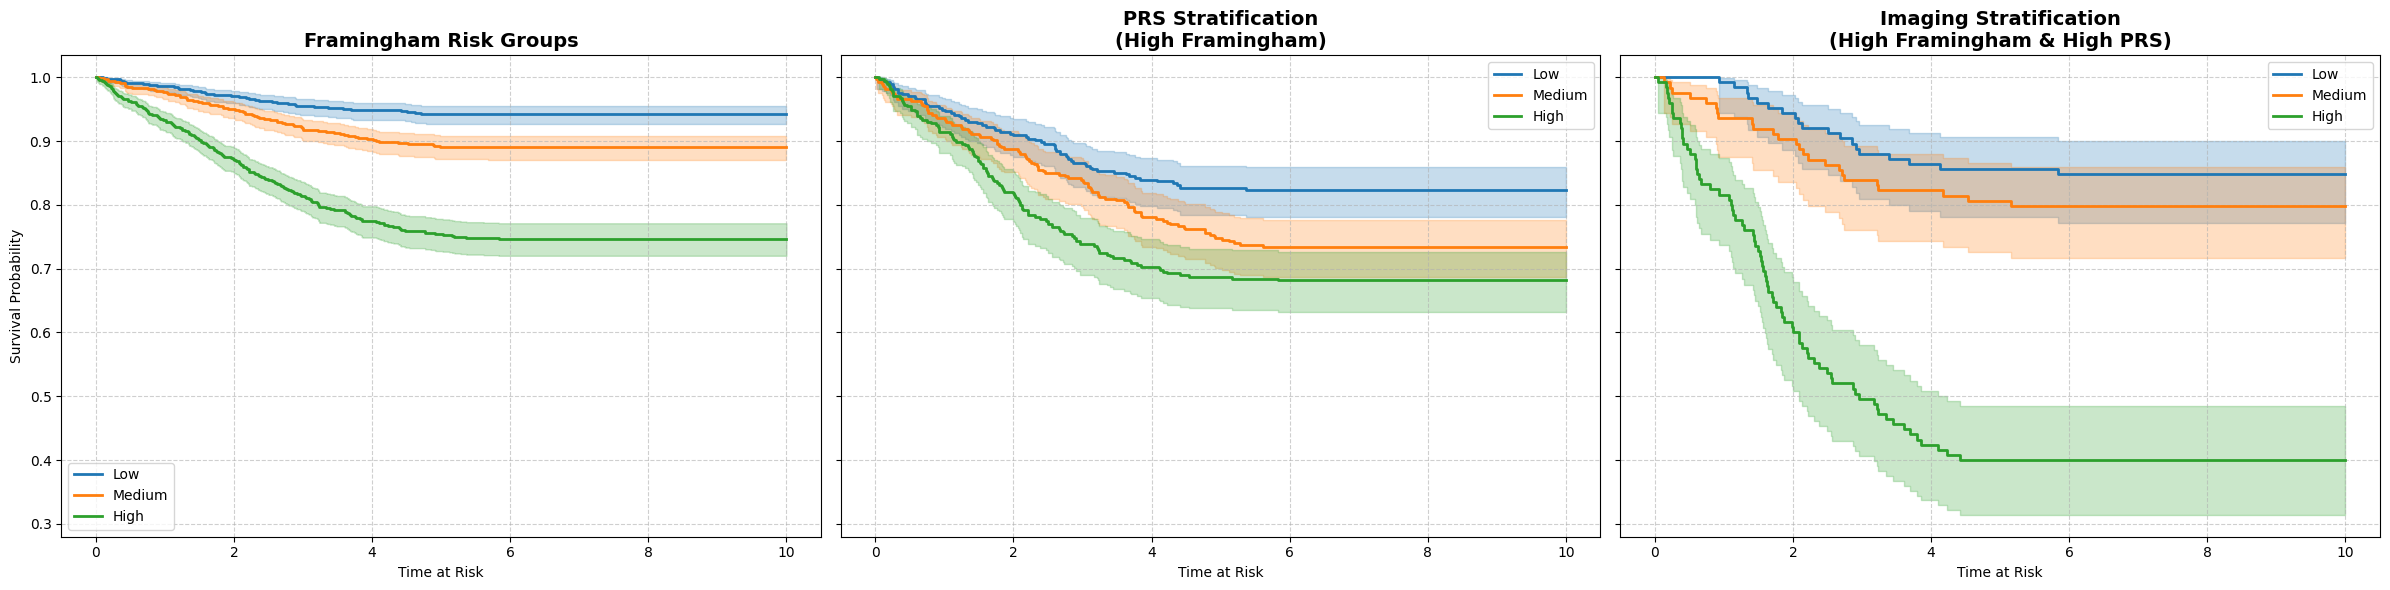

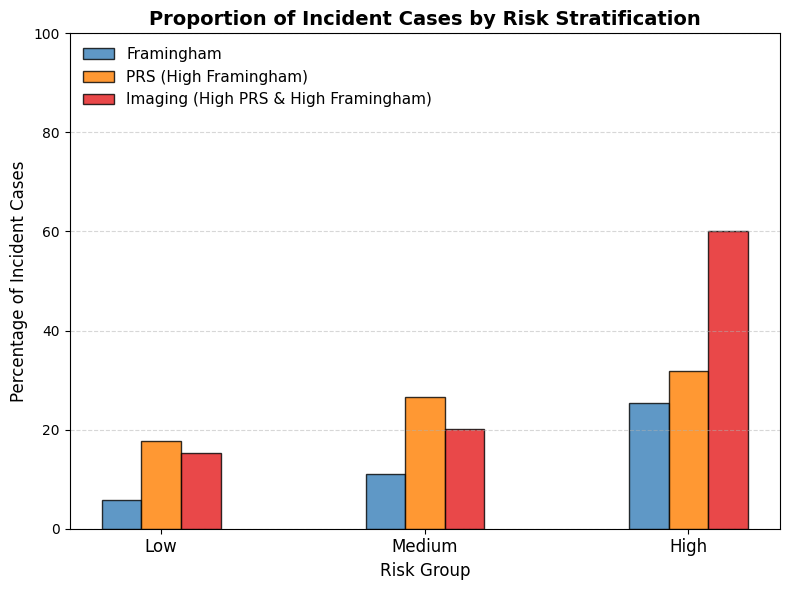

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import StandardScaler
%matplotlib inline
# ----------------------------
# 1. Load Data and Identify Cases
# ----------------------------
cox_train = pd.read_csv('cox_train.csv')
cox_test = pd.read_csv('cox_test.csv')
cox_data = pd.concat([cox_train, cox_test], ignore_index=True)

# Identify prevalent cases: event == 1 and time_at_risk == 0.001
prevalent_mask = (cox_data['event'] == 1) & (cox_data['time_at_risk'] == 0.001)
incident_mask = ~prevalent_mask  # Incident cases (those developing CAD later)
incident_data = cox_data[incident_mask].copy()

# ----------------------------
# 2. Step 1: Framingham Risk Stratification
# ----------------------------
baseline_features = ['age', 'sex', 'bmi', 'smoking']
metabolic_features = ['ldl', 'trig', 'total_cholestrol', 'DM']

# Standardize selected continuous features
features_to_scale = ['age', 'bmi', 'ldl', 'total_cholestrol']
scaler = StandardScaler()
incident_data[features_to_scale] = scaler.fit_transform(incident_data[features_to_scale])

# Fit Cox model for Framingham risk
cph_fram = CoxPHFitter()
cph_fram.fit(incident_data[baseline_features + metabolic_features + ['time_at_risk', 'event']], 
             duration_col='time_at_risk', event_col='event')
incident_data['fram_risk_score'] = cph_fram.predict_partial_hazard(incident_data)

# Stratify into tertiles
incident_data['fram_risk_group'] = pd.qcut(incident_data['fram_risk_score'], q=3, 
                                           labels=['Low', 'Medium', 'High'])

# ----------------------------
# 3. Step 2: PRS Stratification in High Framingham Group
# ----------------------------
incident_data['PRS'] = scaler.fit_transform(incident_data[['PRS']])
high_fram = incident_data[incident_data['fram_risk_group'] == 'High'].copy()
high_fram['PRS_group'] = pd.qcut(high_fram['PRS'], q=3, labels=['Low', 'Medium', 'High'])

# ----------------------------
# 4. Step 3: Imaging Stratification in High Framingham & High PRS Group
# ----------------------------
imaging_features = (
    [f'pca_embedding0_{i}' for i in range(1, 11)] +
    [f'pca_embedding1_{i}' for i in range(1, 11)] +
    [f'pca_embedding2_{i}' for i in range(1, 11)] +
    [f'pca_aortic_embeddings_{i}' for i in range(1, 11)]
)

high_fram[imaging_features] = scaler.fit_transform(high_fram[imaging_features])
high_fram_high_prs = high_fram[high_fram['PRS_group'] == 'High'].copy()

# Fit Cox model for Imaging risk
cph_imaging = CoxPHFitter()
cph_imaging.fit(high_fram_high_prs[imaging_features + ['time_at_risk', 'event']], 
                duration_col='time_at_risk', event_col='event')
high_fram_high_prs['imaging_risk_score'] = cph_imaging.predict_partial_hazard(high_fram_high_prs)

# Stratify into tertiles
high_fram_high_prs['imaging_group'] = pd.qcut(high_fram_high_prs['imaging_risk_score'], q=3, 
                                              labels=['Low', 'Medium', 'High'])

# ----------------------------
# 5. Create Side-by-Side Kaplan–Meier Plots
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
kmf = KaplanMeierFitter()

# Panel 1: Framingham Risk Groups
for group in ['Low', 'Medium', 'High']:
    subset = incident_data[incident_data['fram_risk_group'] == group]
    kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ax=axes[0], ci_show=True, lw=2)
axes[0].set_title('Framingham Risk Groups', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time at Risk')
axes[0].set_ylabel('Survival Probability')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Panel 2: PRS Stratification within High Framingham Risk
for group in ['Low', 'Medium', 'High']:
    subset = high_fram[high_fram['PRS_group'] == group]
    kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ax=axes[1], ci_show=True, lw=2)
axes[1].set_title('PRS Stratification\n(High Framingham)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time at Risk')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Panel 3: Imaging Stratification within High Framingham & High PRS
for group in ['Low', 'Medium', 'High']:
    subset = high_fram_high_prs[high_fram_high_prs['imaging_group'] == group]
    kmf.fit(subset['time_at_risk'], event_observed=subset['event'], label=group)
    kmf.plot_survival_function(ax=axes[2], ci_show=True, lw=2)
axes[2].set_title('Imaging Stratification\n(High Framingham & High PRS)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time at Risk')
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# ----------------------------
# 6. Proportion of Incident Cases per Risk Bin
# ----------------------------
# ----------------------------
# Compute Proportions for Each Risk Type
# ----------------------------
# ----------------------------
# Compute Proportions for Each Risk Type
# ----------------------------
def compute_incident_proportions(df, risk_column):
    """
    Given a dataframe and a risk stratification column, compute the proportion 
    of incident cases out of total individuals in each risk bin.
    """
    proportions = {}
    for group in ['Low', 'Medium', 'High']:
        total_in_bin = len(df[df[risk_column] == group])
        incident_in_bin = len(df[(df[risk_column] == group) & (df['event'] == 1)])
        proportions[group] = (incident_in_bin / total_in_bin) * 100 if total_in_bin > 0 else 0
    return proportions

# Compute proportions for Framingham, PRS, and Imaging groups
fram_proportions = compute_incident_proportions(incident_data, 'fram_risk_group')
prs_proportions = compute_incident_proportions(high_fram, 'PRS_group')
imaging_proportions = compute_incident_proportions(high_fram_high_prs, 'imaging_group')

# ----------------------------
# Plot Slim Bar Chart with Improved Colors
# ----------------------------
risk_categories = ['Low', 'Medium', 'High']
bar_width = 0.15  # Extra slim bars
x = np.arange(len(risk_categories))  # X locations for the groups

fig, ax = plt.subplots(figsize=(8, 6))

# Define improved color scheme
colors = ['#377eb8', '#ff7f00', '#e41a1c']  # Blue, Orange, Red

# Plot the bars
ax.bar(x - bar_width, [fram_proportions[r] for r in risk_categories], bar_width, 
       label='Framingham', color=colors[0], edgecolor='black', alpha=0.8)
ax.bar(x, [prs_proportions[r] for r in risk_categories], bar_width, 
       label='PRS (High Framingham)', color=colors[1], edgecolor='black', alpha=0.8)
ax.bar(x + bar_width, [imaging_proportions[r] for r in risk_categories], bar_width, 
       label='Imaging (High PRS & High Framingham)', color=colors[2], edgecolor='black', alpha=0.8)

# Labels and formatting
ax.set_xlabel("Risk Group", fontsize=12)
ax.set_ylabel("Percentage of Incident Cases", fontsize=12)
ax.set_title("Proportion of Incident Cases by Risk Stratification", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(risk_categories, fontsize=12)
ax.set_ylim(0, 100)
ax.legend(frameon=False, fontsize=11, loc='upper left')

# Add grid for readability
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()